In [11]:
import pandas as pd
assignment_cols = ['StationID', 'Engine', 'Truck', 'Rescue', 'Hazard', 'Squad', 'FAST', 'Medic', 'Brush', 'Boat', 'UTV', 'REACH']
station_cols = ['StationID', 'Facility Name', 'Address', 'City', 'State', 'Zip Code', 'GLOBALID', 'lat', 'lon']
sdf = pd.read_csv("data/stations.csv")
sdf.loc[sdf['Facility Name'] == 'Station 41 / Goodlettesville', 'Facility Name'] = 'Station 41'
sdf['StationID'] = sdf['Facility Name'].str.split(' ').str[1]
sdf = sdf[station_cols]
sdf['StationID'] = sdf['StationID'].astype('int')
sdf = sdf.sort_values(by='StationID')
sdf = sdf.reset_index(drop=True)
sdf['StationID'] = sdf.index
sdf.head()
assignments = []
for k, v in sdf.iterrows():
    values = [v['StationID']] + [2] + [0] * (len(assignment_cols) - 2)
    assignments.append(values)
adf = pd.DataFrame(assignments, columns=assignment_cols)
adf.to_csv("./data/assignments.csv", index=False)
sdf.to_csv("./data/stations.csv", index=False)

<Axes: >

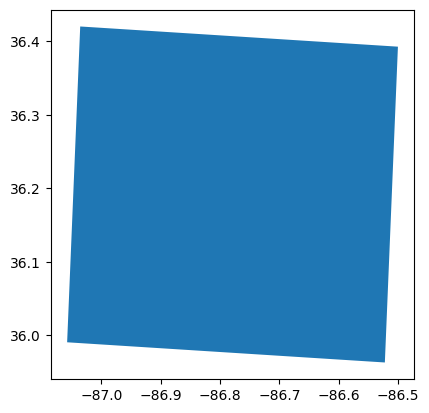

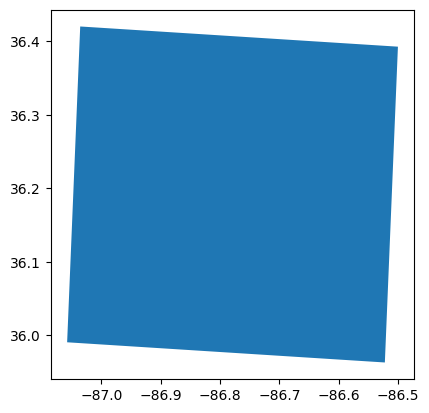

In [12]:
import geopandas as gpd
# Get actual bounds of the city.
df = gpd.read_file("data/bounds.geojson")
df.plot()
df.minimum_rotated_rectangle().to_file("data/bounds_mrr.geojson", driver="GeoJSON")
df.plot()

Text(0.5, 1.0, 'Fire Stations and Incidents')

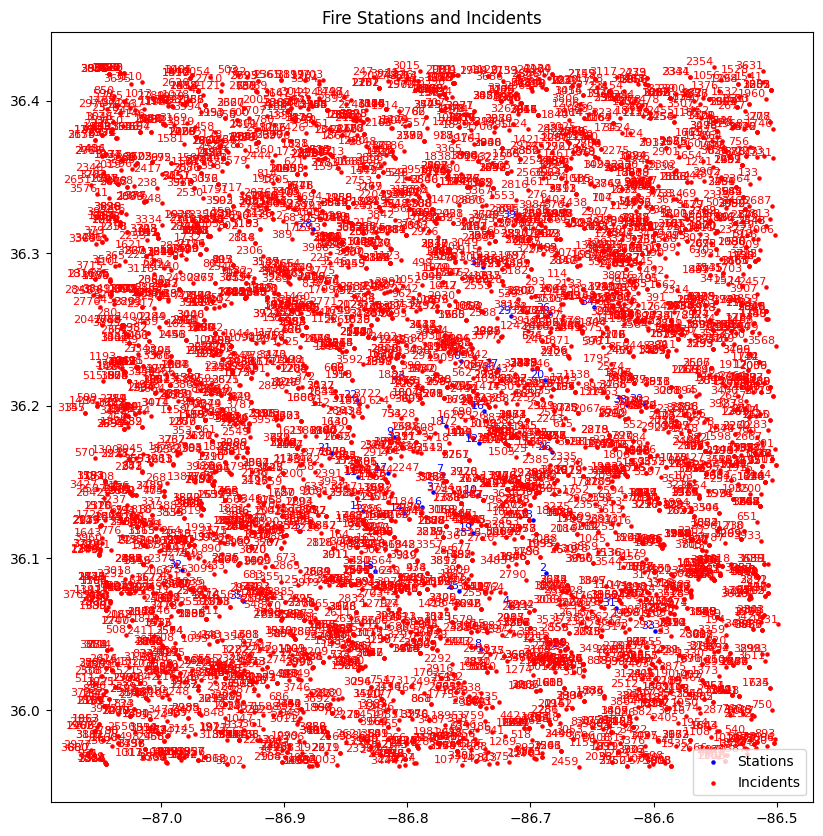

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
stations = pd.read_csv("data/stations.csv")
incidents = pd.read_csv("data/incidents.csv")
# plot the two dataframes on a map
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.lon, stations.lat), crs="EPSG:4326"
)
incidents_gdf = gpd.GeoDataFrame(
    incidents, geometry=gpd.points_from_xy(incidents.lon, incidents.lat), crs="EPSG:4326"
)
fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, color='blue', markersize=5, label='Stations')
incidents_gdf.plot(ax=ax, color='red', markersize=5, label='Incidents')
# add the station and incident labels
for x, y, label in zip(stations_gdf.geometry.x, stations_gdf.geometry.y, stations_gdf['StationID']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='blue')
for x, y, label in zip(incidents_gdf.geometry.x, incidents_gdf.geometry.y, incidents_gdf['incident_id']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='red')
plt.legend()
plt.title('Fire Stations and Incidents')

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import random
import requests

def generate_random_points_within_bounds(bounds, num_points):
    minx, miny, maxx, maxy = bounds.bounds
    points = []
    for _ in range(num_points):
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        points.append(Point(x, y))
    return points

def get_nearest_lat_lon(point, osrm_url):
    response = requests.get(f"{osrm_url}/nearest/v1/driving/{point.x},{point.y}")
    if response.status_code == 200:
        data = response.json()
        if data['waypoints']:
            return data['waypoints'][0]['location']
    return None

def generate_incidents(num_incidents, incident_types, incident_levels, date_range, nearest_points):
    incidents = []
    for idx in range(num_incidents):
        incident_type = random.choice(incident_types)
        incident_level = random.choice(incident_levels)
        date_time = random.choice(date_range)
        lon, lat = random.choice(nearest_points)
        incidents.append({
            "incident_id": f"{idx}",
            "lat": lat,
            "lon": lon,
            "incident_type": incident_type,
            "incident_level": incident_level,
            "datetime": date_time,
        })
    return pd.DataFrame(incidents)

osrm_url = "http://localhost:8080"
num_incidents = 4000
nearest_points = []

# Get actual bounds of the city.
df = gpd.read_file("data/bounds.geojson")
# Generate random points within the bounds.
random_points = generate_random_points_within_bounds(df.unary_union, num_incidents)
# for each point, query the nearest lat lon on the street network with osrm
for point in random_points:
    nearest = get_nearest_lat_lon(point, osrm_url)
    if nearest:
        nearest_points.append(nearest)

incident_types = ["Fire"]
incident_levels = ["Low", "Moderate", "High", "Critical"]
date_range = pd.date_range(start="2023-01-01", end="2023-01-07", freq='15T')

incidents_df = generate_incidents(num_incidents, incident_types, incident_levels, date_range, nearest_points)
incidents_df.to_csv("data/incidents.csv", index=False)

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_47230/3389473152.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  random_points = generate_random_points_within_bounds(df.unary_union, num_incidents)
/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_47230/3389473152.py:57: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start="2023-01-01", end="2023-01-07", freq='15T')


# Results

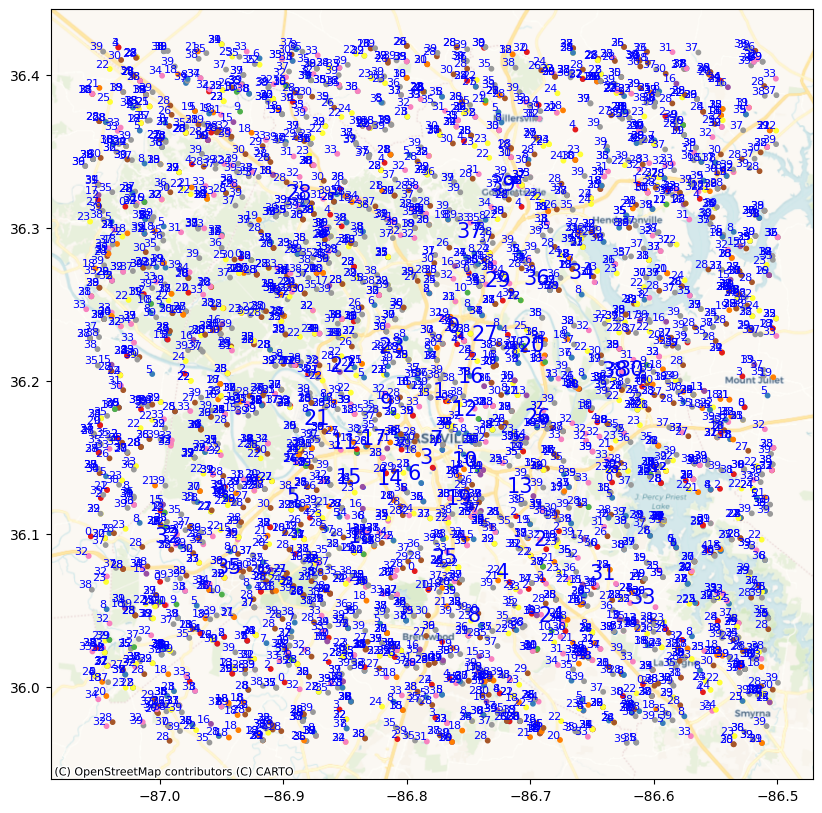

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# add contextily
# Add a basemap with contextily
import contextily as ctx

# show all columns
pd.set_option('display.max_columns', None)

df = pd.read_csv("logs/incident_report.csv")
incidents = pd.read_csv("data/incidents.csv")
stations = pd.read_csv("data/stations.csv")
stations = stations.rename(columns={
    'lat': 'stations_lat',
    'lon': 'stations_lon'
})
df = pd.merge(df, incidents, left_on='IncidentID', right_on='incident_id', how='left')
df = pd.merge(df, stations, on='StationID', how='left')

# plot the incidents and stations on a map
stations_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.stations_lon, df.stations_lat), crs="EPSG:4326"
)
stations_gdf.drop_duplicates(subset=['StationID'], inplace=True)

incidents_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, color='blue', markersize=5, label='Stations')
# station_id = 33
# stations_gdf[stations_gdf['StationID'] == station_id].plot(ax=ax, color='red', markersize=10, label='Station')
# incidents_gdf[incidents_gdf['StationID'] == station_id].plot(ax=ax, color='black', markersize=10, label='Incidents')
stations_gdf.plot(ax=ax, column="StationID", cmap="Set1", markersize=10, label='Station')
incidents_gdf.plot(ax=ax, column="StationID", cmap="Set1", markersize=10, label='Incidents')

# add text to stations
for x, y, label in zip(stations_gdf.geometry.x, stations_gdf.geometry.y, stations_gdf['StationID']):
    ax.text(x, y, label, fontsize=15, ha='right', va='bottom', color='blue')
for x, y, label in zip(incidents_gdf.geometry.x, incidents_gdf.geometry.y, incidents_gdf['StationID']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='blue')

ctx.add_basemap(ax,
               crs=stations_gdf.crs.to_string(),
               source=ctx.providers.CartoDB.Voyager
              )


In [16]:
stations_gdf

,IncidentID,Reported,Responded,Resolved,TravelTime,StationID,EngineCount,incident_id,lat,lon,incident_type,incident_level,datetime,Facility Name,Address,City,State,Zip Code,GLOBALID,stations_lat,stations_lon,geometry
0,3292,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 00:23:54,774.7,28,1,3292,36.019646,-86.852068,Fire,Moderate,2023-01-01 03:00:00,Station 30,3705 Old Clarksville Pike,Joelton,TN,37080,2356f289-594c-4f6a-a925-e07df7d432a4,36.316059,-86.877163,POINT (-86.87716 36.31606)
1,1119,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 01:11:43,643.6,30,1,1119,36.157382,-86.882740,Fire,High,2023-01-05 07:15:00,Station 32,4248 Andrew Jackson Parkway,Hermitage,TN,37076,6787bcae-e112-4d63-9bdc-922bbc9c3b51,36.201147,-86.608002,POINT (-86.608 36.20115)
2,3576,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 01:04:50,230.1,2,1,3576,36.042431,-86.614085,Fire,Moderate,2023-01-06 10:30:00,Station 04,5111 Harding Pl,Nashville,TN,37211,3d7e0969-921f-458d-885e-a1137039d0f6,36.089976,-86.687125,POINT (-86.68713 36.08998)
3,943,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 01:45:23,863.6,39,1,943,36.354706,-86.500988,Fire,Critical,2023-01-05 18:00:00,Station 41,105 Long Hollow Pike,Goodlettsvi,TN,37072,0b6a5ca3-506e-498a-b417-086288790780,36.322112,-86.711666,POINT (-86.71167 36.32211)
4,3221,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 01:35:27,267.7,38,1,3221,35.977711,-86.884314,Fire,Low,2023-01-02 20:45:00,Station 40,4031 Plantation Dr,Hermitage,TN,37076,d24a3407-8b35-4047-b230-3a70cf172545,36.200210,-86.621341,POINT (-86.62134 36.20021)
6,1666,2023-01-01 00:00:00,2023-01-01 00:01:00,2023-01-01 01:44:42,822.9,35,1,1666,36.381075,-86.778124,Fire,High,2023-01-02 14:15:00,Station 37,646 Colice Jeanne Rd,Nashville,TN,37138,fc16c182-b70e-42b4-83a5-e383784ccfae,36.071918,-86.933649,POINT (-86.93365 36.07192)
8,2720,2023-01-01 00:15:00,2023-01-01 00:16:00,2023-01-01 00:51:27,327.7,23,1,2720,36.053714,-86.659342,Fire,High,2023-01-01 13:00:00,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770,36.216178,-86.801437,POINT (-86.80144 36.21618)
10,2631,2023-01-01 00:15:00,2023-01-01 00:16:00,2023-01-01 01:49:09,189.3,26,1,2631,36.280411,-86.536945,Fire,Low,2023-01-01 01:15:00,Station 28,2394 Lebanon Rd,Nashville,TN,37214,152a3eef-ade9-47f8-850c-4c2c6d4c6d28,36.169451,-86.682791,POINT (-86.68279 36.16945)
17,2964,2023-01-01 00:30:00,2023-01-01 00:31:00,2023-01-01 01:08:28,448.2,32,1,2964,36.223843,-86.923896,Fire,Low,2023-01-03 21:00:00,Station 34,8350 Highway 70 S,Nashville,TN,37221,0ed70936-c5b6-4344-881f-d8d554feb08b,36.092094,-86.983004,POINT (-86.983 36.09209)
20,2116,2023-01-01 00:45:00,2023-01-01 00:46:00,2023-01-01 01:15:49,1189.9,37,1,2116,36.267513,-86.943202,Fire,High,2023-01-05 02:00:00,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a,36.291075,-86.738605,POINT (-86.7386 36.29108)


In [17]:
incidents_gdf[incidents_gdf['StationID'] == 37].City.unique()

array(['Goodlettsvi'], dtype=object)

/var/folders/tf/7k8vj9w17715wv9yqsqn7pm00000gq/T/ipykernel_47230/3127850903.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = group.unary_union.convex_hull


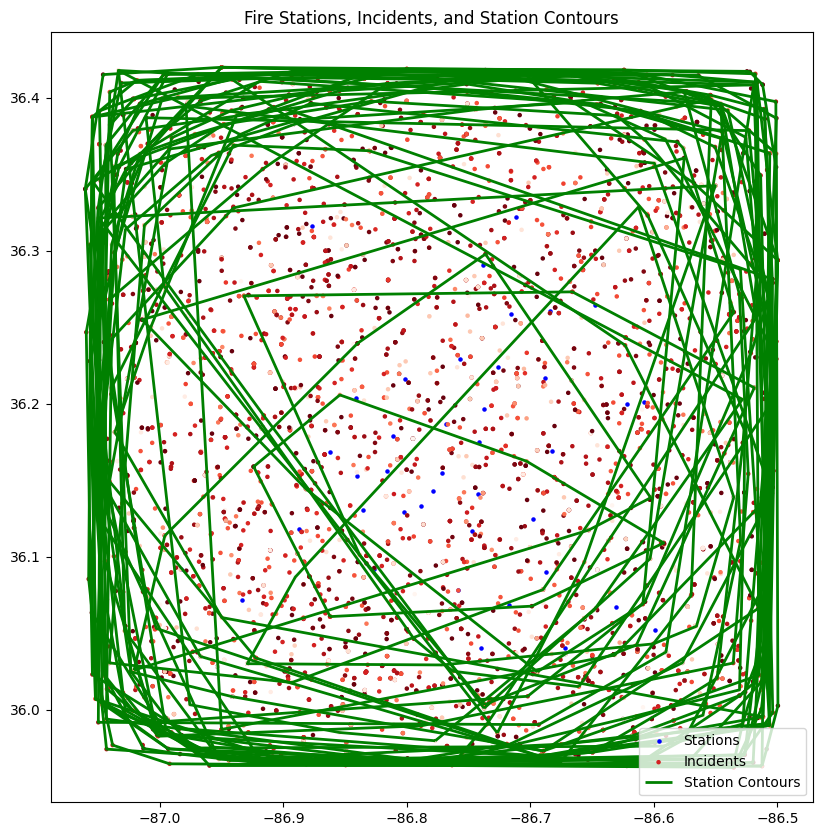

In [18]:
# Group incidents by StationID and create convex hulls
contours = []
for station_id, group in incidents_gdf.groupby('StationID'):
    if len(group) > 2:  # Need at least 3 points for a polygon
        hull = group.unary_union.convex_hull
        contours.append({'StationID': station_id, 'geometry': hull})

contours_gdf = gpd.GeoDataFrame(contours, crs="EPSG:4326")

# Plot stations, incidents, and contours
fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, color='blue', markersize=5, label='Stations')
incidents_gdf.plot(ax=ax, column='StationID', cmap='Reds', markersize=5, label='Incidents')
contours_gdf.boundary.plot(ax=ax, color='green', linewidth=2, label='Station Contours')

plt.legend()
plt.title('Fire Stations, Incidents, and Station Contours')
plt.show()

Modifying the actual dataset

In [15]:

import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon
from shapely import wkt

#was reading incidents_grids.csv
fire_incidents= pd.read_csv("data/incidents_grids.csv")
# fire_incidents = pd.read_excel("data/NFIRS100_2022_Present/Incidents_100_2022_Present.xlsx")

fire_incidents = gpd.GeoDataFrame(
    fire_incidents,
    geometry=gpd.points_from_xy(fire_incidents.Longitude, fire_incidents.Latitude),
    crs="EPSG:4326"
)
# fire_incidents = fire_incidents[fire_incidents.NFIRSType == 'Fire'].reset_index(drop=True)
fire_incidents.rename(columns={

    'Latitude': 'lat',
    'Longitude': 'lon',
    'NFIRSType': 'incident_type',
    'PSAPDate': 'datetime'
}
, inplace=True)

In [8]:
apparatus = pd.read_excel("/Users/ammarbinzulqarnain/Documents/Scope Lab/Project/fire_simulator/data/NFIRS100_2022_Present/Apparatus2022_Present.xlsx")

In [12]:
cols = [ 'Apparatus_Resource_ID',
 'Apparatus_Resource_Use',
 'VehicleType',
 'Apparatus_Resource_Type',
 'Apparatus_Resource_Type_Category']
apparatus[cols].dropna(subset='Apparatus_Resource_Type')

,Apparatus_Resource_ID,Apparatus_Resource_Use,VehicleType,Apparatus_Resource_Type,Apparatus_Resource_Type_Category
0,MED18,EMS,Medic,ALS unit,Medical & Rescue Unit
1,EN33,Suppression,Engine,Engine,Ground Fire Suppression
2,MED05,EMS,Medic,ALS unit,Medical & Rescue Unit
3,FST09,Suppression,Fast,"Ground fire suppression, other",Ground Fire Suppression
4,FST32,Suppression,Fast,"Ground fire suppression, other",Ground Fire Suppression
...,...,...,...,...,...
1364336,EN05,Suppression,Engine,Engine,Ground Fire Suppression
1364337,MED18,EMS,Medic,ALS unit,Medical & Rescue Unit
1364338,EN33,Suppression,Engine,Engine,Ground Fire Suppression
1364339,EN31,Suppression,Engine,Engine,Ground Fire Suppression


In [ ]:
# import numpy as np
# fire_incidents['Resolution_Time']=np.abs(fire_incidents['AlarmFirstUnitArriveTime']-fire_incidents[ 'AlarmLastUnitClearTime'])/60


KeyError: 'AlarmFirstUnitArriveTime'

In [19]:

counts = fire_incidents['SuppressionApparatusCount']

# 1) compute the percentile cut-points
q60, q80, q95 = counts.quantile([0.60, 0.80, 0.95])

# 2) define bins using those values
bins = [-np.inf, q60, q80, q95, np.inf]
labels = ["Low", "Moderate", "High", "Critical"]

# 3) cut into a new categorical column
fire_incidents['incident_level'] = pd.cut(
    counts,
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [20]:
fire_incidents.sort_values(by='datetime', inplace=True)
fire_incidents.reset_index(drop=True, inplace=True)
fire_incidents['incident_id'] = fire_incidents.index.astype(int)

In [21]:
if type(fire_incidents.datetime.iloc[0]) == str:
    fire_incidents.datetime=fire_incidents.datetime.str[:-4]  # remove milliseconds

In [22]:
fire_incidents[['incident_id', 'lat', 'lon', 'incident_type', 'incident_level', 'datetime']]
fire_incidents['datetime']=fire_incidents['datetime'].apply(str)

In [31]:
fire_incidents.datetime.iloc[0]

'2022-01-01 00:58:14'

In [32]:
export_incidents = fire_incidents[['incident_id', 'lat', 'lon', 'incident_type', 'incident_level', 'datetime']]

In [ ]:
export_incidents=export_incidents[export_incidents.incident_level.notna()]

,incident_id,lat,lon,incident_type,incident_level,datetime
123483,123483,36.126438,-86.753937,Good Intent Call,NaN,2023-02-10 17:18:18
174903,174903,36.171674,-86.810286,NaN,NaN,2023-07-22 16:42:00
243748,243748,36.100199,-86.821388,EMS & Rescue,NaN,2024-02-23 15:26:00
243749,243749,36.153521,-86.777511,Good Intent Call,NaN,2024-02-23 15:30:51
243750,243750,36.169224,-86.779667,Good Intent Call,NaN,2024-02-23 15:34:00
243751,243751,36.166285,-86.808010,Good Intent Call,NaN,2024-02-23 15:40:27
243753,243753,36.144126,-86.622877,EMS & Rescue,NaN,2024-02-23 15:41:26
308833,308833,36.219757,-86.793769,Service Call,NaN,2024-09-11 15:53:00


In [33]:
#drop rows with NaN values in 'lat' or 'lon'
export_incidents = export_incidents.dropna(subset=['lat', 'lon','incident_level'])
export_incidents.to_csv("data/old_incidents_2022_2024.csv", index=False)
